## Data gathering

In [1]:
!wget -q http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
!unzip -qq camera_scene_detection_train.zip

## Imports

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from tqdm import tqdm
from imutils import paths
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

tf.random.set_seed(42)
np.random.seed(42)

## Data parsing

In [3]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
print(image_paths[:5])

['training/2_Group_portrait/221.jpg', 'training/29_QR_images/126.jpg', 'training/16_Blue_Sky/144.jpg', 'training/18_Greenery/157.jpg', 'training/22_Stage_concert/36.jpg']


In [4]:
labels = []
for image_path in tqdm(image_paths):
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count) 

100%|██████████| 9897/9897 [00:00<00:00, 162122.05it/s]

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '16_Blue_Sky': 322,
         '22_Stage_concert': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


## Define the hyparameters

In [5]:
TRAIN_SPLIT = 0.9
IMG_SIZE = 224
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
EPOCHS = 100
NUM_CLASSES = 30

## Split the dataset

In [6]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

8907 990


## Encode the labels

In [7]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[21 20  6  8 13]


## Dataloader

In [8]:
@tf.function
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) # No rescaling since EfficientNetB1 internally does it
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

## Apply data augmentation

In [9]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

## Convert the data into TensorFlow Dataset objects

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))

## Data pipeline

In [11]:
pipeline_train = (
    train_ds
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

pipeline_validation = (
    val_ds
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Determine class weights

In [12]:
trainLabels = keras.utils.to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Model building and training

In [13]:
def get_training_model(trainable=False):
    # Load the EfficientNetB1 model but exclude the classification layers
    EXTRACTOR = keras.applications.EfficientNetB1(weights="imagenet", include_top=False,
                    input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # We will set it to both True and False
    EXTRACTOR.trainable = trainable
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = layers.GlobalAveragePooling2D()(class_head)
    class_head = layers.Dense(512, activation="relu")(class_head)
    class_head = layers.Dropout(0.5)(class_head)
    class_head = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(class_head)

    # Create the new model
    classifier = keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

## Plot the metric

In [14]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc"], loc="upper left")
    plt.grid()
    plt.show()

    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_loss", "val_loss"], loc="upper left")
    plt.grid()
    plt.show()

## Setup callbacks

In [15]:
train_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.CSVLogger('train-logs.csv')
]

## Train the model

27033600/27018416 [==============================] - 1s 0us/step
Epoch 1/100
35/35 [==============================] - 131s 3s/step - loss: 1.7961 - accuracy: 0.7142 - val_loss: 0.4213 - val_accuracy: 0.8879
Epoch 2/100
35/35 [==============================] - 103s 3s/step - loss: 0.5576 - accuracy: 0.8928 - val_loss: 0.3512 - val_accuracy: 0.9051
Epoch 3/100
35/35 [==============================] - 109s 3s/step - loss: 0.4359 - accuracy: 0.9191 - val_loss: 0.3167 - val_accuracy: 0.9131
Epoch 4/100
35/35 [==============================] - 104s 3s/step - loss: 0.3653 - accuracy: 0.9288 - val_loss: 0.3013 - val_accuracy: 0.9121
Epoch 5/100
35/35 [==============================] - 108s 3s/step - loss: 0.3113 - accuracy: 0.9384 - val_loss: 0.2793 - val_accuracy: 0.9232
Epoch 6/100
35/35 [==============================] - 107s 3s/step - loss: 0.2744 - accuracy: 0.9452 - val_loss: 0.2777 - val_accuracy: 0.9182
Epoch 7/100
35/35 [==============================] - 104s 3s/step - loss: 0.2336 - 

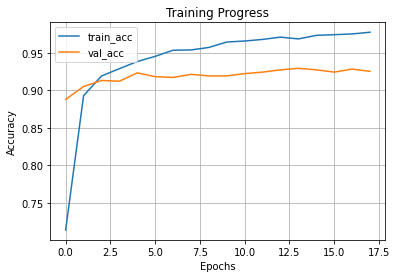

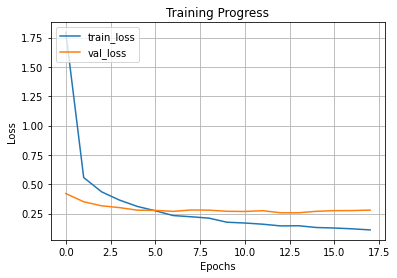

In [16]:
classifier = get_training_model()

h = classifier.fit(pipeline_train,
               validation_data=pipeline_validation,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE,
               class_weight=classWeight,
               callbacks=train_callbacks)

accuracy = classifier.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

plot_hist(h)

## Predict the images

In [18]:
test_prediction = np.argmax(classifier.predict(pipeline_validation), 1)
print(test_prediction.shape)

(990,)


## Confusion matrix

In [ ]:
print(confusion_matrix(validation_labels_le, test_prediction))

## Classification report

In [23]:
print(classification_report(validation_labels_le, test_prediction))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94        37
           1       0.97      0.90      0.94        41
           2       0.82      0.79      0.81        34
           3       0.97      1.00      0.99        37
           4       0.88      0.96      0.92        54
           5       0.91      0.91      0.91        45
           6       0.85      0.72      0.78        40
           7       0.89      0.57      0.69        30
           8       0.89      0.91      0.90        34
           9       0.96      0.86      0.91        28
          10       0.86      0.91      0.89        35
          11       0.97      0.94      0.95        33
          12       0.97      0.97      0.97        30
          13       0.96      1.00      0.98        25
          14       1.00      1.00      1.00        37
          15       1.00      0.97      0.98        31
          16       1.00      1.00      1.00        24
          17       0.95    

## Serialize the model

In [24]:
classifier.save('image_scene_model')

INFO:tensorflow:Assets written to: image_scene_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [25]:
!tar -cvf "image_scene_model.tar" "image_scene_model"

image_scene_model/
image_scene_model/keras_metadata.pb
image_scene_model/saved_model.pb
image_scene_model/assets/
image_scene_model/variables/
image_scene_model/variables/variables.index
image_scene_model/variables/variables.data-00000-of-00001
